### Import the needed packages

In [2]:
# package for using the the custom scripts 
import sys
sys.path.insert(0, "./../")
# package for handling files and directories
import os
# package for handling the training hyperparameter tracking
import wandb
# a custom package for handling the data
import utilities as utils
# package for handling the versioning of the models
from huggingface_hub import HfApi
# package for handling the environment variables
from dotenv import load_dotenv
# get the environment variables
load_dotenv()
# set the wandb api to silent
os.environ["WANDB_SILENT"] = "true"

### Global variable

In [3]:
# store the path
path_full = os.environ.get("ORI_PATH")
path_dataset_ori = os.path.join(path_full, "datasets", "splitted", "original")
path_dataset_aug = os.path.join(path_full, "datasets", "splitted", "augmented")
path_model = os.path.join(path_full, "data", "model")
ori_path = {
    "train": os.path.join(path_dataset_ori, "train"),
    "val": os.path.join(path_dataset_ori, "val"),
    "test": os.path.join(path_dataset_ori, "test"),
}
aug_path = {
    "train": os.path.join(path_dataset_aug, "train"),
    "val": os.path.join(path_dataset_aug, "val"),
    "test": os.path.join(path_dataset_aug, "test"),
}
# tensorboard log path
log_dir = os.path.join(path_full, "data", "logs")
# the commit message
wandb_init_name = "retrain the model with new config"
hf_commit_message = "retrain the model with new config"
# the hyperparameter for the training
hyperparam = {
    "batch_size": 16,
    "epochs": 50,
    "img_size": 128,
    "shuffle": True,
    "model_type": "U-net",
    "metrics": ["accuracy", "auc", "MeanIoU", "Precision", "Recall"],
    "split_ratio": [7,1,2],
    "dataset_balance": True,
    "weighted_training": True,
    "aug": False,
}

### Create Tensorboard log dir

In [4]:
os.makedirs(log_dir, exist_ok=True)

### Import the images and mask

In [5]:
# get the original dataset
train_ori_img, train_ori_mask = utils.load_img_mask(ori_path["train"])
val_ori_img, val_ori_mask = utils.load_img_mask(ori_path["val"])
test_ori_img, test_ori_mask = utils.load_img_mask(ori_path["test"])

# get the augmented dataset
train_aug_img, train_aug_mask = utils.load_img_mask(aug_path["train"])
val_aug_img, val_aug_mask = utils.load_img_mask(aug_path["val"])
test_aug_img, test_aug_mask = utils.load_img_mask(aug_path["test"])

### Create the batched dataset

In [6]:
# create the tensor dataset for original dataset
trainset_ori = utils.create_dataset(train_ori_img, train_ori_mask, hyperparam["img_size"], hyperparam["batch_size"])
valset_ori = utils.create_dataset(val_ori_img, val_ori_mask, hyperparam["img_size"], hyperparam["batch_size"])
testset_ori = utils.create_dataset(test_ori_img, test_ori_mask, hyperparam["img_size"], hyperparam["batch_size"])

# create the tensor dataset for augmented dataset
trainset_aug = utils.create_dataset(train_aug_img, train_aug_mask, hyperparam["img_size"], hyperparam["batch_size"])
valset_aug = utils.create_dataset(val_aug_img, val_aug_mask, hyperparam["img_size"], hyperparam["batch_size"])
testset_aug = utils.create_dataset(test_aug_img, test_aug_mask, hyperparam["img_size"], hyperparam["batch_size"])

### Train model

### Unet

In [34]:
# create the unet model
unet_custom = utils.custom_unet()
file_model_name = "unet_model_ori"
# train the model using original dataset
unet_custom, history, ev_result = utils.train_model(unet_custom,
                                                trainset_ori, valset_ori, testset_ori,
                                                path_model, file_model_name, os.path.join(log_dir, "unet_ori"),
                                                hyperparam["epochs"])
# show the evaluation result
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 11s 190ms/step - loss: 0.0096 - mean_px_acc: 0.3449 - auc: 0.7441 - precision: 0.5697 - recall: 0.4699 - val_loss: 0.0099 - val_mean_px_acc: 0.4055 - val_auc: 0.7765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 7s 121ms/step - loss: 0.0070 - mean_px_acc: 0.5140 - auc: 0.8585 - precision: 0.7113 - recall: 0.6243 - val_loss: 0.0099 - val_mean_px_acc: 0.9264 - val_auc: 0.8784 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 7s 126ms/step - loss: 0.0058 - mean_px_acc: 0.5967 - auc: 0.9035 - precision: 0.7885 - recall: 0.6394 - val_loss: 0.0100 - val_mean_px_acc: 0.9873 - val_auc: 0.7562 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
16/16 [==============================] - 7s 123ms/step - loss: 0.0055 - mean_px_acc: 0.7250 - auc: 0.9187 - precision: 0.8135 - recall: 0.6416 - val_loss: 0.0106 - val_mean_px_ac

In [8]:
# initiate the huggingface api 
api = HfApi()
repo = api.create_repo("CAD-Glaucoma_Segmentation", repo_type="model", exist_ok=True)

In [9]:
# push the model artifact and hyperparameter to wandb
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"unet_ori - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [10]:
# push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"unet_ori - {hf_commit_message}",
)

unet_model_ori.h5: 100%|██████████| 1.57M/1.57M [00:02<00:00, 551kB/s] 


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/1751a67641cdf4d829491f91ae6be3e838e72f57', commit_message='unet_ori - retrain the model with new config', commit_description='', oid='1751a67641cdf4d829491f91ae6be3e838e72f57', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

In [33]:
# create the unet model
unet_custom = utils.custom_unet()
file_model_name = "unet_model_aug"
# train the model using augmented dataset
unet_custom, history, ev_result = utils.train_model(unet_custom,
                                                trainset_aug, valset_aug, testset_aug,
                                                path_model, file_model_name, os.path.join(log_dir, "unet_aug"),
                                                hyperparam["epochs"])
# show the evaluation result 
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 9s 194ms/step - loss: 0.0086 - mean_px_acc: 0.4517 - auc: 0.8009 - precision: 0.6559 - recall: 0.5496 - val_loss: 0.0100 - val_mean_px_acc: 0.9230 - val_auc: 0.8691 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 4s 114ms/step - loss: 0.0061 - mean_px_acc: 0.5141 - auc: 0.8967 - precision: 0.7699 - recall: 0.6581 - val_loss: 0.0101 - val_mean_px_acc: 0.9858 - val_auc: 0.7126 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 4s 118ms/step - loss: 0.0054 - mean_px_acc: 0.6401 - auc: 0.9197 - precision: 0.8137 - recall: 0.6915 - val_loss: 0.0103 - val_mean_px_acc: 0.9850 - val_auc: 0.6421 - val_precision: 1.0000 - val_recall: 0.0060
Epoch 4/50
16/16 [==============================] - 4s 116ms/step - loss: 0.0050 - mean_px_acc: 0.7742 - auc: 0.9332 - precision: 0.8389 - recall: 0.7138 - val_loss: 0.0107 - val_mean_px_acc: 0.9831

In [12]:
# push the model artifact and hyperparameter to wandb
## set the hyperparameter for the wandb
hyperparam["aug"] = True
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"unet_aug - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [13]:
## push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"unet_aug - {hf_commit_message}",
)

unet_model_aug.h5: 100%|██████████| 1.57M/1.57M [00:01<00:00, 1.03MB/s]


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/7c5b19577d38778e9f4989ddf70daf576a3a933f', commit_message='unet_aug - retrain the model with new config', commit_description='', oid='7c5b19577d38778e9f4989ddf70daf576a3a933f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

### MobileNet

In [14]:
# create the unet model
mobilenet = utils.mobilenet_model()
file_model_name = "mnet_model_ori"
# train the model using original dataset
mobilenet, history, ev_result = utils.train_model(mobilenet,
                                                trainset_ori, valset_ori, testset_ori,
                                                path_model, file_model_name, os.path.join(log_dir, "mnet_ori"),
                                                hyperparam["epochs"])
# show the evaluation result
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 29s 552ms/step - loss: 0.0096 - mean_px_acc: 0.4348 - auc: 0.7340 - precision: 0.5608 - recall: 0.4728 - val_loss: 0.0147 - val_mean_px_acc: 0.3877 - val_auc: 0.6800 - val_precision: 0.4309 - val_recall: 0.4051
Epoch 2/50
16/16 [==============================] - 10s 169ms/step - loss: 0.0077 - mean_px_acc: 0.6055 - auc: 0.8231 - precision: 0.6625 - recall: 0.5550 - val_loss: 0.0150 - val_mean_px_acc: 0.4971 - val_auc: 0.6915 - val_precision: 0.4634 - val_recall: 0.4313
Epoch 3/50
16/16 [==============================] - 9s 172ms/step - loss: 0.0070 - mean_px_acc: 0.7107 - auc: 0.8579 - precision: 0.7158 - recall: 0.5897 - val_loss: 0.0109 - val_mean_px_acc: 0.6425 - val_auc: 0.7483 - val_precision: 0.5453 - val_recall: 0.5014
Epoch 4/50
16/16 [==============================] - 10s 185ms/step - loss: 0.0066 - mean_px_acc: 0.7893 - auc: 0.8795 - precision: 0.7371 - recall: 0.6327 - val_loss: 0.0080 - val_mean_px_acc: 0.6963 - val_auc: 0

In [15]:
# initiate the huggingface api 
api = HfApi()
repo = api.create_repo("CAD-Glaucoma_Segmentation", repo_type="model", exist_ok=True)

In [16]:
# push the model artifact and hyperparameter to wandb
## set the hyperparameter for the wandb
hyperparam["aug"] = False
hyperparam["model_type"] = "MobileNet"
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"mnet_ori - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [17]:
## push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"mnet_ori - {hf_commit_message}",
)

mnet_model_ori.h5: 100%|██████████| 46.5M/46.5M [00:28<00:00, 1.60MB/s]


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/e6a89e6147972e2aa67a9abaf86e5317af7226fc', commit_message='mnet_ori - retrain the model with new config', commit_description='', oid='e6a89e6147972e2aa67a9abaf86e5317af7226fc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

In [18]:
# create the unet model
mobilenet = utils.mobilenet_model()
file_model_name = "mnet_model_aug"
# train the model using augmented dataset
mobilenet, history, ev_result = utils.train_model(mobilenet,
                                                trainset_aug, valset_aug, testset_aug,
                                                path_model, file_model_name, os.path.join(log_dir, "mnet_aug"),
                                                hyperparam["epochs"])
# show the evaluation result
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 20s 515ms/step - loss: 0.0100 - mean_px_acc: 0.4492 - auc: 0.7391 - precision: 0.5444 - recall: 0.4752 - val_loss: 0.0152 - val_mean_px_acc: 0.5317 - val_auc: 0.7413 - val_precision: 0.5224 - val_recall: 0.5188
Epoch 2/50
16/16 [==============================] - 5s 153ms/step - loss: 0.0078 - mean_px_acc: 0.5790 - auc: 0.8172 - precision: 0.6536 - recall: 0.5378 - val_loss: 0.0106 - val_mean_px_acc: 0.5398 - val_auc: 0.7707 - val_precision: 0.5709 - val_recall: 0.5615
Epoch 3/50
16/16 [==============================] - 5s 165ms/step - loss: 0.0070 - mean_px_acc: 0.6994 - auc: 0.8587 - precision: 0.7078 - recall: 0.5887 - val_loss: 0.0089 - val_mean_px_acc: 0.5827 - val_auc: 0.7683 - val_precision: 0.5453 - val_recall: 0.5221
Epoch 4/50
16/16 [==============================] - 4s 117ms/step - loss: 0.0065 - mean_px_acc: 0.7799 - auc: 0.8840 - precision: 0.7424 - recall: 0.6345 - val_loss: 0.0081 - val_mean_px_acc: 0.5550 - val_auc: 0.7

In [19]:
# initiate the huggingface api 
api = HfApi()
repo = api.create_repo("CAD-Glaucoma_Segmentation", repo_type="model", exist_ok=True)

In [20]:
# push the model artifact and hyperparameter to wandb
## set the hyperparameter for the wandb
hyperparam["aug"] = True
hyperparam["model_type"] = "MobileNet"
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"mnet_aug - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [21]:
## push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"mnet_aug - {hf_commit_message}",
)

mnet_model_aug.h5: 100%|██████████| 46.5M/46.5M [00:29<00:00, 1.58MB/s]


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/fc7c69018aa9e5cea8fd3a932b97afbf639187c5', commit_message='mnet_aug - retrain the model with new config', commit_description='', oid='fc7c69018aa9e5cea8fd3a932b97afbf639187c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

### EfficientNet

In [22]:
# create the unet model
efficientnet = utils.efficientnet_model()
file_model_name = "efnet_model_ori"
# train the model using original dataset
efficientnet, history, ev_result = utils.train_model(efficientnet,
                                                trainset_ori, valset_ori, testset_ori,
                                                path_model, file_model_name, os.path.join(log_dir, "efnet_ori"),
                                                hyperparam["epochs"])
# show the evaluation result
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 135s 3s/step - loss: 0.0084 - mean_px_acc: 0.3978 - auc: 0.8112 - precision: 0.6732 - recall: 0.5324 - val_loss: 0.0310 - val_mean_px_acc: 0.9685 - val_auc: 0.5561 - val_precision: 0.3173 - val_recall: 0.3171
Epoch 2/50
16/16 [==============================] - 23s 761ms/step - loss: 0.0060 - mean_px_acc: 0.6369 - auc: 0.9000 - precision: 0.7884 - recall: 0.6534 - val_loss: 0.0197 - val_mean_px_acc: 0.9224 - val_auc: 0.6799 - val_precision: 0.5894 - val_recall: 0.5856
Epoch 3/50
16/16 [==============================] - 27s 895ms/step - loss: 0.0054 - mean_px_acc: 0.7120 - auc: 0.9180 - precision: 0.8158 - recall: 0.6651 - val_loss: 0.0128 - val_mean_px_acc: 0.8766 - val_auc: 0.7666 - val_precision: 0.6435 - val_recall: 0.6336
Epoch 4/50
16/16 [==============================] - 21s 700ms/step - loss: 0.0049 - mean_px_acc: 0.7975 - auc: 0.9373 - precision: 0.8430 - recall: 0.6981 - val_loss: 0.0094 - val_mean_px_acc: 0.9090 - val_auc: 0.

In [23]:
# initiate the huggingface api 
api = HfApi()
repo = api.create_repo("CAD-Glaucoma_Segmentation", repo_type="model", exist_ok=True)

In [24]:
# push the model artifact and hyperparameter to wandb
## set the hyperparameter for the wandb
hyperparam["aug"] = False
hyperparam["model_type"] = "EfficientNet"
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"efnet_ori - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [25]:
## push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"efnet_ori - {hf_commit_message}",
)

efnet_model_ori.h5: 100%|██████████| 256M/256M [02:42<00:00, 1.57MB/s] 


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/09d30db039a14d08f0479e032d9c7c016a4372b0', commit_message='efnet_ori - retrain the model with new config', commit_description='', oid='09d30db039a14d08f0479e032d9c7c016a4372b0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

In [26]:
# create the unet model
efficientnet = utils.efficientnet_model()
file_model_name = "efnet_model_aug"
# train the model using original dataset
efficientnet, history, ev_result = utils.train_model(efficientnet,
                                                trainset_aug, valset_aug, testset_aug,
                                                path_model, file_model_name, os.path.join(log_dir, "efnet_aug"),
                                                hyperparam["epochs"])
# show the evaluation result
print(f"test loss: {ev_result[0]}", f"test mean_px_acc: {ev_result[1]}",
        f"test auc: {ev_result[2]}", f"test precision: {ev_result[3]}",
        f"test recall: {ev_result[4]}", sep="\n")

Epoch 1/50
16/16 [==============================] - 44s 645ms/step - loss: 0.0081 - mean_px_acc: 0.4563 - auc: 0.8255 - precision: 0.6870 - recall: 0.5948 - val_loss: 0.0702 - val_mean_px_acc: 0.9760 - val_auc: 0.4377 - val_precision: 0.2741 - val_recall: 0.2741
Epoch 2/50
16/16 [==============================] - 6s 298ms/step - loss: 0.0056 - mean_px_acc: 0.5999 - auc: 0.9103 - precision: 0.8054 - recall: 0.6799 - val_loss: 0.0350 - val_mean_px_acc: 0.9795 - val_auc: 0.5366 - val_precision: 0.2745 - val_recall: 0.2742
Epoch 3/50
16/16 [==============================] - 6s 305ms/step - loss: 0.0051 - mean_px_acc: 0.7374 - auc: 0.9304 - precision: 0.8350 - recall: 0.6848 - val_loss: 0.0205 - val_mean_px_acc: 0.9826 - val_auc: 0.5919 - val_precision: 0.2908 - val_recall: 0.2905
Epoch 4/50
16/16 [==============================] - 7s 304ms/step - loss: 0.0048 - mean_px_acc: 0.8631 - auc: 0.9421 - precision: 0.8530 - recall: 0.7157 - val_loss: 0.0078 - val_mean_px_acc: 0.9861 - val_auc: 0.8

In [27]:
# initiate the huggingface api 
api = HfApi()
repo = api.create_repo("CAD-Glaucoma_Segmentation", repo_type="model", exist_ok=True)

In [28]:
# push the model artifact and hyperparameter to wandb
## set the hyperparameter for the wandb
hyperparam["aug"] = True
hyperparam["model_type"] = "EfficientNet"
## initiate the project
wandb.init(project="CAD - Glaucoma Segmentation",
            name=f"efnet_aug - {wandb_init_name}",
            config=hyperparam)
## write the training history and validation result to wandb log
for epoch in range(len(history.history["loss"])):
    wandb.log({
        "train_loss": history.history["loss"][epoch],
        "train_accuracy": history.history["mean_px_acc"][epoch],
        "train_auc": history.history["auc"][epoch],
        "train_precision": history.history["precision"][epoch],
        "train_recall": history.history["recall"][epoch],
        "train_f1": 2 * (history.history["precision"][epoch] * history.history["recall"][epoch]) / (history.history["precision"][epoch] + history.history["recall"][epoch] + 1e-7),
        "val_loss": history.history["val_loss"][epoch],
        "val_accuracy": history.history["val_mean_px_acc"][epoch],
        "val_auc": history.history["val_auc"][epoch],
        "val_precision": history.history["val_precision"][epoch],
        "val_recall": history.history["val_recall"][epoch],
        "val_f1": 2 * (history.history["val_precision"][epoch] * history.history["val_recall"][epoch]) / (history.history["val_precision"][epoch] + history.history["val_recall"][epoch] + 1e-7),
    })
## store the model artifact
wandb.log_artifact(os.path.join(path_model, f"{file_model_name}.h5"))
wandb.finish()

In [29]:
## push the model to the huggingface hub
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj=os.path.join(path_model, f"{file_model_name}.h5"),
    path_in_repo=f"model/{file_model_name}.h5",
    repo_type=repo.repo_type,
    commit_message=f"efnet_aug - {hf_commit_message}",
)

efnet_model_aug.h5: 100%|██████████| 256M/256M [02:40<00:00, 1.59MB/s]   


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation/commit/9cb7432c99fc3d2f28f588d287806252a0027206', commit_message='efnet_aug - retrain the model with new config', commit_description='', oid='9cb7432c99fc3d2f28f588d287806252a0027206', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/CAD-Glaucoma_Segmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/CAD-Glaucoma_Segmentation'), pr_revision=None, pr_num=None)

### Experiment

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
test_model = utils.custom_load_model(os.path.join(path_model, "unet_model_ori.h5"))

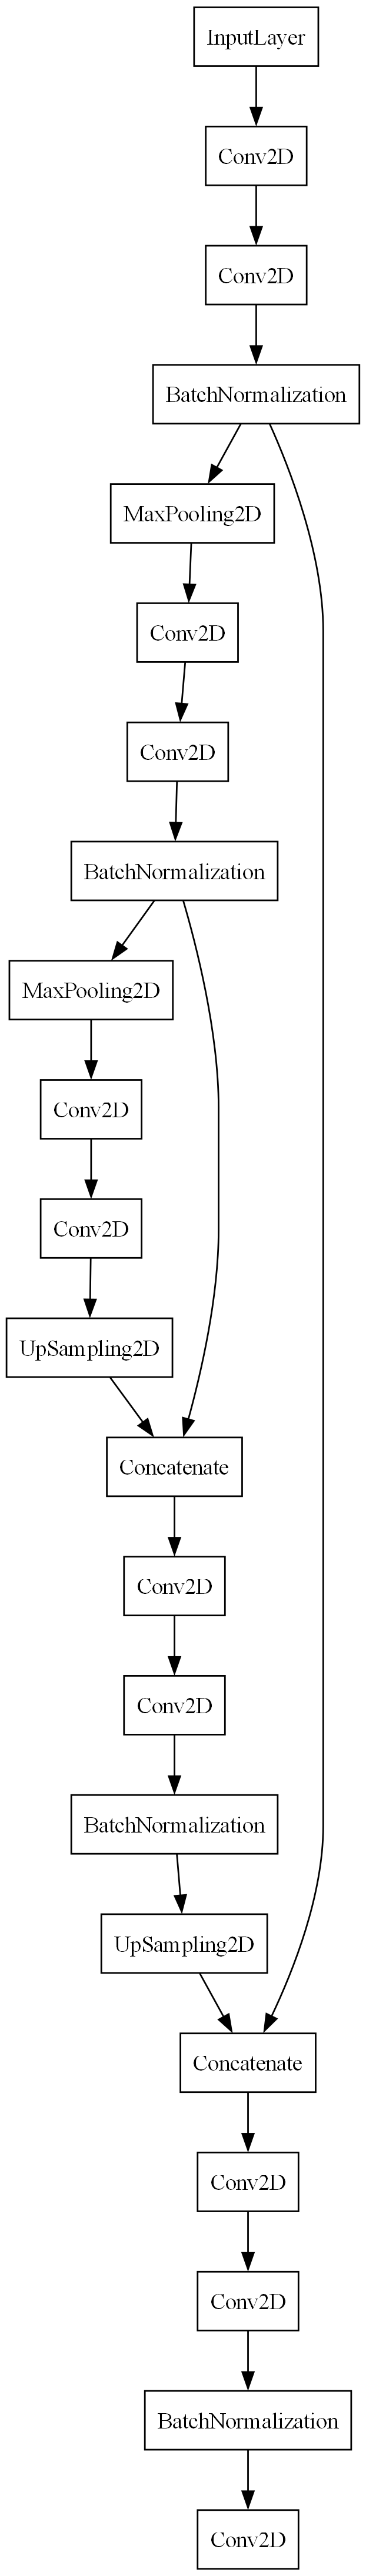

In [32]:
tf.keras.utils.plot_model(test_model,
                            to_file='test.png',
                            # rankdir="LR",
                            show_layer_names=False,
                            dpi=200)